In [ ]:
"""
Approach:
- create a bag-of-words for each of: fact1, fact2, question, answer.
- remove stopwords, as well as sentence punctuation and all verbs.
- create 2-grams using the bag-of-words

Evaluation:
- using this method, given that one of the facts states where john is, 
  we can say where he is correctly with high certainty and probability.

Limitations:
- approach only works for previously seen people and places
- if the given facts do not contain the answer to the question, 
  we don't know with certainty where the person is, as we don't keep previous facts in memory.
  
  (note the model does remember places john has been to in the past 
  based on previous examples in the training data and thus scores 
  some places more likely than others)
  
Next Steps:
- could add a 7th "don't know/can't remember" answer given low certainty, would have to relabel 
  train/test data.
  
- discover a way that the classifier can remember where the person was last
- discover a way to generalise the model to unseen people and places
"""

In [11]:
import os
import sys
%reload_ext autoreload
%autoreload
%matplotlib inline

project_root = os.path.abspath(os.path.join('../../../'))
if project_root not in sys.path:
    sys.path.append(project_root)

In [12]:
import pandas as pd
from ml_workbench.src.data_loaders.BablTask1Loader import split_parse_data

X_train, y_train = split_parse_data('/Users/enrico.t/code/ml_workbench/' + 
  'data/tasks_1-20_v1-2/en/qa1_single-supporting-fact_train.txt')

X_test, y_test = split_parse_data('/Users/enrico.t/code/ml_workbench/' + 
 'data/tasks_1-20_v1-2/en/qa1_single-supporting-fact_test.txt')

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from ml_workbench.src.vectorizers.ColumnBowVectorizer import ColumnBowVectorizer

pipeline = Pipeline([
    ('bow', ColumnBowVectorizer()),
    ('clf', SVC(probability=True))
])

parameters = {
    'clf__C': [ 1, 5, 10, 100],
    'clf__gamma': [1, 0.1, 0.001],
    'bow__ngrams': [[2,3]]
}

grid = GridSearchCV(
    pipeline, 
    parameters, 
    cv=3,
    n_jobs=-1, 
    verbose=1
)

grid.fit(X_train, y_train)
y_predict = grid.predict(X_test)
print grid.best_params_

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


JoblibValueError: JoblibValueError
___________________________________________________________________________
...........................................................................
/usr/local/Cellar/python@2/2.7.15_1/Frameworks/Python.framework/Versions/2.7/lib/python2.7/runpy.py in _run_module_as_main(mod_name='ipykernel_launcher', alter_argv=1)
    169     pkg_name = mod_name.rpartition('.')[0]
    170     main_globals = sys.modules["__main__"].__dict__
    171     if alter_argv:
    172         sys.argv[0] = fname
    173     return _run_code(code, main_globals, None,
--> 174                      "__main__", fname, loader, pkg_name)
        fname = '/Users/enrico.t/code/ml_workbench/venv/lib/python2.7/site-packages/ipykernel_launcher.py'
        loader = <pkgutil.ImpLoader instance>
        pkg_name = ''
    175 
    176 def run_module(mod_name, init_globals=None,
    177                run_name=None, alter_sys=False):
    178     """Execute a module's code without importing it

...........................................................................
/usr/local/Cellar/python@2/2.7.15_1/Frameworks/Python.framework/Versions/2.7/lib/python2.7/runpy.py in _run_code(code=<code object <module> at 0x10d8eb1b0, file "/Use...2.7/site-packages/ipykernel_launcher.py", line 5>, run_globals={'__builtins__': <module '__builtin__' (built-in)>, '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/Users/enrico.t/code/ml_workbench/venv/lib/python2.7/site-packages/ipykernel_launcher.py', '__loader__': <pkgutil.ImpLoader instance>, '__name__': '__main__', '__package__': '', 'app': <module 'ipykernel.kernelapp' from '/Users/enric...python2.7/site-packages/ipykernel/kernelapp.pyc'>, 'sys': <module 'sys' (built-in)>}, init_globals=None, mod_name='__main__', mod_fname='/Users/enrico.t/code/ml_workbench/venv/lib/python2.7/site-packages/ipykernel_launcher.py', mod_loader=<pkgutil.ImpLoader instance>, pkg_name='')
     67         run_globals.update(init_globals)
     68     run_globals.update(__name__ = mod_name,
     69                        __file__ = mod_fname,
     70                        __loader__ = mod_loader,
     71                        __package__ = pkg_name)
---> 72     exec code in run_globals
        code = <code object <module> at 0x10d8eb1b0, file "/Use...2.7/site-packages/ipykernel_launcher.py", line 5>
        run_globals = {'__builtins__': <module '__builtin__' (built-in)>, '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/Users/enrico.t/code/ml_workbench/venv/lib/python2.7/site-packages/ipykernel_launcher.py', '__loader__': <pkgutil.ImpLoader instance>, '__name__': '__main__', '__package__': '', 'app': <module 'ipykernel.kernelapp' from '/Users/enric...python2.7/site-packages/ipykernel/kernelapp.pyc'>, 'sys': <module 'sys' (built-in)>}
     73     return run_globals
     74 
     75 def _run_module_code(code, init_globals=None,
     76                     mod_name=None, mod_fname=None,

...........................................................................
/Users/enrico.t/code/ml_workbench/venv/lib/python2.7/site-packages/ipykernel_launcher.py in <module>()
     11     # This is added back by InteractiveShellApp.init_path()
     12     if sys.path[0] == '':
     13         del sys.path[0]
     14 
     15     from ipykernel import kernelapp as app
---> 16     app.launch_new_instance()

...........................................................................
/Users/enrico.t/code/ml_workbench/venv/lib/python2.7/site-packages/traitlets/config/application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
/Users/enrico.t/code/ml_workbench/venv/lib/python2.7/site-packages/ipykernel/kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    494         if self.poller is not None:
    495             self.poller.start()
    496         self.kernel.start()
    497         self.io_loop = ioloop.IOLoop.current()
    498         try:
--> 499             self.io_loop.start()
        self.io_loop.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    500         except KeyboardInterrupt:
    501             pass
    502 
    503 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
/Users/enrico.t/code/ml_workbench/venv/lib/python2.7/site-packages/tornado/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
   1068                 self._events.update(event_pairs)
   1069                 while self._events:
   1070                     fd, events = self._events.popitem()
   1071                     try:
   1072                         fd_obj, handler_func = self._handlers[fd]
-> 1073                         handler_func(fd_obj, events)
        handler_func = <function null_wrapper>
        fd_obj = <zmq.sugar.socket.Socket object>
        events = 1
   1074                     except (OSError, IOError) as e:
   1075                         if errno_from_exception(e) == errno.EPIPE:
   1076                             # Happens when the client closes the connection
   1077                             pass

...........................................................................
/Users/enrico.t/code/ml_workbench/venv/lib/python2.7/site-packages/tornado/stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    295         # Fast path when there are no active contexts.
    296         def null_wrapper(*args, **kwargs):
    297             try:
    298                 current_state = _state.contexts
    299                 _state.contexts = cap_contexts[0]
--> 300                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    301             finally:
    302                 _state.contexts = current_state
    303         null_wrapper._wrapped = True
    304         return null_wrapper

...........................................................................
/Users/enrico.t/code/ml_workbench/venv/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    445             return
    446         zmq_events = self.socket.EVENTS
    447         try:
    448             # dispatch events:
    449             if zmq_events & zmq.POLLIN and self.receiving():
--> 450                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    451                 if not self.socket:
    452                     return
    453             if zmq_events & zmq.POLLOUT and self.sending():
    454                 self._handle_send()

...........................................................................
/Users/enrico.t/code/ml_workbench/venv/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    475             else:
    476                 raise
    477         else:
    478             if self._recv_callback:
    479                 callback = self._recv_callback
--> 480                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    481         
    482 
    483     def _handle_send(self):
    484         """Handle a send event."""

...........................................................................
/Users/enrico.t/code/ml_workbench/venv/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    427         close our socket."""
    428         try:
    429             # Use a NullContext to ensure that all StackContexts are run
    430             # inside our blanket exception handler rather than outside.
    431             with stack_context.NullContext():
--> 432                 callback(*args, **kwargs)
        callback = <function null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    433         except:
    434             gen_log.error("Uncaught exception in ZMQStream callback",
    435                           exc_info=True)
    436             # Re-raise the exception so that IOLoop.handle_callback_exception

...........................................................................
/Users/enrico.t/code/ml_workbench/venv/lib/python2.7/site-packages/tornado/stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    295         # Fast path when there are no active contexts.
    296         def null_wrapper(*args, **kwargs):
    297             try:
    298                 current_state = _state.contexts
    299                 _state.contexts = cap_contexts[0]
--> 300                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    301             finally:
    302                 _state.contexts = current_state
    303         null_wrapper._wrapped = True
    304         return null_wrapper

...........................................................................
/Users/enrico.t/code/ml_workbench/venv/lib/python2.7/site-packages/ipykernel/kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    278         if self.control_stream:
    279             self.control_stream.on_recv(self.dispatch_control, copy=False)
    280 
    281         def make_dispatcher(stream):
    282             def dispatcher(msg):
--> 283                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    284             return dispatcher
    285 
    286         for s in self.shell_streams:
    287             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
/Users/enrico.t/code/ml_workbench/venv/lib/python2.7/site-packages/ipykernel/kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {u'allow_stdin': True, u'code': u"from sklearn.pipeline import Pipeline\nfrom sk... = grid.predict(X_test)\nprint grid.best_params_", u'silent': False, u'stop_on_error': True, u'store_history': True, u'user_expressions': {}}, 'header': {u'date': datetime.datetime(2018, 12, 18, 16, 14, 12, 566627, tzinfo=tzutc()), u'msg_id': u'4401a013b82f46cf8615ebb3cb257047', u'msg_type': u'execute_request', u'session': u'bc97d81ca49e488e8168330f6ad42cda', u'username': u'username', u'version': u'5.2'}, 'metadata': {}, 'msg_id': u'4401a013b82f46cf8615ebb3cb257047', 'msg_type': u'execute_request', 'parent_header': {}})
    228             self.log.warning("Unknown message type: %r", msg_type)
    229         else:
    230             self.log.debug("%s: %s", msg_type, msg)
    231             self.pre_handler_hook()
    232             try:
--> 233                 handler(stream, idents, msg)
        handler = <bound method IPythonKernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = ['bc97d81ca49e488e8168330f6ad42cda']
        msg = {'buffers': [], 'content': {u'allow_stdin': True, u'code': u"from sklearn.pipeline import Pipeline\nfrom sk... = grid.predict(X_test)\nprint grid.best_params_", u'silent': False, u'stop_on_error': True, u'store_history': True, u'user_expressions': {}}, 'header': {u'date': datetime.datetime(2018, 12, 18, 16, 14, 12, 566627, tzinfo=tzutc()), u'msg_id': u'4401a013b82f46cf8615ebb3cb257047', u'msg_type': u'execute_request', u'session': u'bc97d81ca49e488e8168330f6ad42cda', u'username': u'username', u'version': u'5.2'}, 'metadata': {}, 'msg_id': u'4401a013b82f46cf8615ebb3cb257047', 'msg_type': u'execute_request', 'parent_header': {}}
    234             except Exception:
    235                 self.log.error("Exception in message handler:", exc_info=True)
    236             finally:
    237                 self.post_handler_hook()

...........................................................................
/Users/enrico.t/code/ml_workbench/venv/lib/python2.7/site-packages/ipykernel/kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=['bc97d81ca49e488e8168330f6ad42cda'], parent={'buffers': [], 'content': {u'allow_stdin': True, u'code': u"from sklearn.pipeline import Pipeline\nfrom sk... = grid.predict(X_test)\nprint grid.best_params_", u'silent': False, u'stop_on_error': True, u'store_history': True, u'user_expressions': {}}, 'header': {u'date': datetime.datetime(2018, 12, 18, 16, 14, 12, 566627, tzinfo=tzutc()), u'msg_id': u'4401a013b82f46cf8615ebb3cb257047', u'msg_type': u'execute_request', u'session': u'bc97d81ca49e488e8168330f6ad42cda', u'username': u'username', u'version': u'5.2'}, 'metadata': {}, 'msg_id': u'4401a013b82f46cf8615ebb3cb257047', 'msg_type': u'execute_request', 'parent_header': {}})
    394         if not silent:
    395             self.execution_count += 1
    396             self._publish_execute_input(code, parent, self.execution_count)
    397 
    398         reply_content = self.do_execute(code, silent, store_history,
--> 399                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    400 
    401         # Flush output before sending the reply.
    402         sys.stdout.flush()
    403         sys.stderr.flush()

...........................................................................
/Users/enrico.t/code/ml_workbench/venv/lib/python2.7/site-packages/ipykernel/ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code=u"from sklearn.pipeline import Pipeline\nfrom sk... = grid.predict(X_test)\nprint grid.best_params_", silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    203 
    204         self._forward_input(allow_stdin)
    205 
    206         reply_content = {}
    207         try:
--> 208             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = u"from sklearn.pipeline import Pipeline\nfrom sk... = grid.predict(X_test)\nprint grid.best_params_"
        store_history = True
        silent = False
    209         finally:
    210             self._restore_input()
    211 
    212         if res.error_before_exec is not None:

...........................................................................
/Users/enrico.t/code/ml_workbench/venv/lib/python2.7/site-packages/ipykernel/zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=(u"from sklearn.pipeline import Pipeline\nfrom sk... = grid.predict(X_test)\nprint grid.best_params_",), **kwargs={'silent': False, 'store_history': True})
    532             )
    533         self.payload_manager.write_payload(payload)
    534 
    535     def run_cell(self, *args, **kwargs):
    536         self._last_traceback = None
--> 537         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = (u"from sklearn.pipeline import Pipeline\nfrom sk... = grid.predict(X_test)\nprint grid.best_params_",)
        kwargs = {'silent': False, 'store_history': True}
    538 
    539     def _showtraceback(self, etype, evalue, stb):
    540         # try to preserve ordering of tracebacks and print statements
    541         sys.stdout.flush()

...........................................................................
/Users/enrico.t/code/ml_workbench/venv/lib/python2.7/site-packages/IPython/core/interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell=u"from sklearn.pipeline import Pipeline\nfrom sk... = grid.predict(X_test)\nprint grid.best_params_", store_history=True, silent=False, shell_futures=True)
   2709                 self.displayhook.exec_result = result
   2710 
   2711                 # Execute the user code
   2712                 interactivity = "none" if silent else self.ast_node_interactivity
   2713                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2714                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler instance>
   2715                 
   2716                 self.last_execution_succeeded = not has_raised
   2717 
   2718                 # Reset this so later displayed values do not modify the

...........................................................................
/Users/enrico.t/code/ml_workbench/venv/lib/python2.7/site-packages/IPython/core/interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.ImportFrom object>, <_ast.ImportFrom object>, <_ast.ImportFrom object>, <_ast.ImportFrom object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Expr object>, <_ast.Assign object>, <_ast.Print object>], cell_name='<ipython-input-14-c338e21c7b01>', interactivity='none', compiler=<IPython.core.compilerop.CachingCompiler instance>, result=<ExecutionResult object at 11cb92750, execution_..._before_exec=None error_in_exec=None result=None>)
   2813 
   2814         try:
   2815             for i, node in enumerate(to_run_exec):
   2816                 mod = ast.Module([node])
   2817                 code = compiler(mod, cell_name, "exec")
-> 2818                 if self.run_code(code, result):
        self.run_code = <bound method ZMQInteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x11ccdda30, file "<ipython-input-14-c338e21c7b01>", line 25>
        result = <ExecutionResult object at 11cb92750, execution_..._before_exec=None error_in_exec=None result=None>
   2819                     return True
   2820 
   2821             for i, node in enumerate(to_run_interactive):
   2822                 mod = ast.Interactive([node])

...........................................................................
/Users/enrico.t/code/ml_workbench/venv/lib/python2.7/site-packages/IPython/core/interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x11ccdda30, file "<ipython-input-14-c338e21c7b01>", line 25>, result=<ExecutionResult object at 11cb92750, execution_..._before_exec=None error_in_exec=None result=None>)
   2873         outflag = 1  # happens in more places, so it's easier as default
   2874         try:
   2875             try:
   2876                 self.hooks.pre_run_code_hook()
   2877                 #rprint('Running code', repr(code_obj)) # dbg
-> 2878                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x11ccdda30, file "<ipython-input-14-c338e21c7b01>", line 25>
        self.user_global_ns = {'ColumnBowVectorizer': <class 'ml_workbench.src.vectorizers.ColumnBowVectorizer.ColumnBowVectorizer'>, 'ConfusionMatrix': <class 'pandas_ml.confusion_matrix.cm.ConfusionMatrix'>, 'GridSearchCV': <class 'sklearn.model_selection._search.GridSearchCV'>, 'In': ['', u'"""\nApproach:\n- create a bag-of-words for ea...ise the model to unseen people and places\n\n"""', u"import os\nimport sys\nget_ipython().magic(u'r... in sys.path:\n    sys.path.append(project_root)", u"import pandas as pd\nfrom ml_workbench.src.dat...20_v1-2/en/qa1_single-supporting-fact_test.txt')", u"from sklearn.pipeline import Pipeline\nfrom sk... = grid.predict(X_test)\nprint grid.best_params_", u'from pandas_ml import ConfusionMatrix\n\ncm = ...t.values.flatten(), y_predict)\ncm.print_stats()', u'cm.plot()', u'y_proba_predict = grid.predict_proba(X_test)\n...hallway, as one of the given facts attests to it', u'print X_test.iloc[1], y_test.iloc[1]\nprint y_...the given facts where john is, low probabilities', u"# actually a previous fact states that mary is...nly\n# be known if fact 2 happened after fact 1.", u"from sklearn.pipeline import Pipeline\nfrom sk... = grid.predict(X_test)\nprint grid.best_params_", u"import os\nimport sys\nget_ipython().magic(u'r... in sys.path:\n    sys.path.append(project_root)", u"import pandas as pd\nfrom ml_workbench.src.dat...20_v1-2/en/qa1_single-supporting-fact_test.txt')", u"from sklearn.pipeline import Pipeline\nfrom sk... = grid.predict(X_test)\nprint grid.best_params_", u"from sklearn.pipeline import Pipeline\nfrom sk... = grid.predict(X_test)\nprint grid.best_params_"], 'Out': {1: '\nApproach:\n- create a bag-of-words for each of: ...eneralise the model to unseen people and places\n\n', 6: <matplotlib.axes._subplots.AxesSubplot object>}, 'Pipeline': <class 'sklearn.pipeline.Pipeline'>, 'SVC': <class 'sklearn.svm.classes.SVC'>, 'X_test':                                  fact1          ...999    Where is John?   

[1000 rows x 3 columns], 'X_train':                                  fact1          ...999  Where is Daniel?   

[1000 rows x 3 columns], '_': <matplotlib.axes._subplots.AxesSubplot object>, ...}
        self.user_ns = {'ColumnBowVectorizer': <class 'ml_workbench.src.vectorizers.ColumnBowVectorizer.ColumnBowVectorizer'>, 'ConfusionMatrix': <class 'pandas_ml.confusion_matrix.cm.ConfusionMatrix'>, 'GridSearchCV': <class 'sklearn.model_selection._search.GridSearchCV'>, 'In': ['', u'"""\nApproach:\n- create a bag-of-words for ea...ise the model to unseen people and places\n\n"""', u"import os\nimport sys\nget_ipython().magic(u'r... in sys.path:\n    sys.path.append(project_root)", u"import pandas as pd\nfrom ml_workbench.src.dat...20_v1-2/en/qa1_single-supporting-fact_test.txt')", u"from sklearn.pipeline import Pipeline\nfrom sk... = grid.predict(X_test)\nprint grid.best_params_", u'from pandas_ml import ConfusionMatrix\n\ncm = ...t.values.flatten(), y_predict)\ncm.print_stats()', u'cm.plot()', u'y_proba_predict = grid.predict_proba(X_test)\n...hallway, as one of the given facts attests to it', u'print X_test.iloc[1], y_test.iloc[1]\nprint y_...the given facts where john is, low probabilities', u"# actually a previous fact states that mary is...nly\n# be known if fact 2 happened after fact 1.", u"from sklearn.pipeline import Pipeline\nfrom sk... = grid.predict(X_test)\nprint grid.best_params_", u"import os\nimport sys\nget_ipython().magic(u'r... in sys.path:\n    sys.path.append(project_root)", u"import pandas as pd\nfrom ml_workbench.src.dat...20_v1-2/en/qa1_single-supporting-fact_test.txt')", u"from sklearn.pipeline import Pipeline\nfrom sk... = grid.predict(X_test)\nprint grid.best_params_", u"from sklearn.pipeline import Pipeline\nfrom sk... = grid.predict(X_test)\nprint grid.best_params_"], 'Out': {1: '\nApproach:\n- create a bag-of-words for each of: ...eneralise the model to unseen people and places\n\n', 6: <matplotlib.axes._subplots.AxesSubplot object>}, 'Pipeline': <class 'sklearn.pipeline.Pipeline'>, 'SVC': <class 'sklearn.svm.classes.SVC'>, 'X_test':                                  fact1          ...999    Where is John?   

[1000 rows x 3 columns], 'X_train':                                  fact1          ...999  Where is Daniel?   

[1000 rows x 3 columns], '_': <matplotlib.axes._subplots.AxesSubplot object>, ...}
   2879             finally:
   2880                 # Reset our crash handler in place
   2881                 sys.excepthook = old_excepthook
   2882         except SystemExit as e:

...........................................................................
/Users/enrico.t/code/ml_workbench/babI-tasks/question_1/<ipython-input-14-c338e21c7b01> in <module>()
     20     cv=3,
     21     n_jobs=-1, 
     22     verbose=1
     23 )
     24 
---> 25 grid.fit(X_train, y_train)
     26 y_predict = grid.predict(X_test)
     27 print grid.best_params_

...........................................................................
/Users/enrico.t/code/ml_workbench/venv/lib/python2.7/site-packages/sklearn/model_selection/_search.py in fit(self=GridSearchCV(cv=3, error_score='raise-deprecatin...ain_score='warn',
       scoring=None, verbose=1), X=                                 fact1          ...999  Where is Daniel?   

[1000 rows x 3 columns], y=       answer
0    bathroom
1     hallway
2     ...   bedroom
999    garden

[1000 rows x 1 columns], groups=None, **fit_params={})
    717                 # instead of results_container
    718                 results_container[0] = self._format_results(
    719                     all_candidate_params, scorers, n_splits, all_out)
    720                 return results_container[0]
    721 
--> 722             self._run_search(evaluate_candidates)
        self._run_search = <bound method GridSearchCV._run_search of GridSe...in_score='warn',
       scoring=None, verbose=1)>
        evaluate_candidates = <function evaluate_candidates>
    723 
    724         results = results_container[0]
    725 
    726         # For multi-metric evaluation, store the best_index_, best_params_ and

...........................................................................
/Users/enrico.t/code/ml_workbench/venv/lib/python2.7/site-packages/sklearn/model_selection/_search.py in _run_search(self=GridSearchCV(cv=3, error_score='raise-deprecatin...ain_score='warn',
       scoring=None, verbose=1), evaluate_candidates=<function evaluate_candidates>)
   1186         self.param_grid = param_grid
   1187         _check_param_grid(param_grid)
   1188 
   1189     def _run_search(self, evaluate_candidates):
   1190         """Search all candidates in param_grid"""
-> 1191         evaluate_candidates(ParameterGrid(self.param_grid))
        evaluate_candidates = <function evaluate_candidates>
        self.param_grid = {'bow__ngrams': [[2, 3]], 'clf__C': [1, 5, 10, 100], 'clf__gamma': [1, 0.1, 0.001]}
   1192 
   1193 
   1194 class RandomizedSearchCV(BaseSearchCV):
   1195     """Randomized search on hyper parameters.

...........................................................................
/Users/enrico.t/code/ml_workbench/venv/lib/python2.7/site-packages/sklearn/model_selection/_search.py in evaluate_candidates(candidate_params=[{'bow__ngrams': [2, 3], 'clf__C': 1, 'clf__gamma': 1}, {'bow__ngrams': [2, 3], 'clf__C': 1, 'clf__gamma': 0.1}, {'bow__ngrams': [2, 3], 'clf__C': 1, 'clf__gamma': 0.001}, {'bow__ngrams': [2, 3], 'clf__C': 5, 'clf__gamma': 1}, {'bow__ngrams': [2, 3], 'clf__C': 5, 'clf__gamma': 0.1}, {'bow__ngrams': [2, 3], 'clf__C': 5, 'clf__gamma': 0.001}, {'bow__ngrams': [2, 3], 'clf__C': 10, 'clf__gamma': 1}, {'bow__ngrams': [2, 3], 'clf__C': 10, 'clf__gamma': 0.1}, {'bow__ngrams': [2, 3], 'clf__C': 10, 'clf__gamma': 0.001}, {'bow__ngrams': [2, 3], 'clf__C': 100, 'clf__gamma': 1}, {'bow__ngrams': [2, 3], 'clf__C': 100, 'clf__gamma': 0.1}, {'bow__ngrams': [2, 3], 'clf__C': 100, 'clf__gamma': 0.001}])
    706                                                        train=train, test=test,
    707                                                        parameters=parameters,
    708                                                        **fit_and_score_kwargs)
    709                                for parameters, (train, test)
    710                                in product(candidate_params,
--> 711                                           cv.split(X, y, groups)))
    712 
    713                 all_candidate_params.extend(candidate_params)
    714                 all_out.extend(out)
    715 

...........................................................................
/Users/enrico.t/code/ml_workbench/venv/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=Parallel(n_jobs=-1), iterable=<generator object <genexpr>>)
    991                 # No need to wait for async callbacks to trigger to
    992                 # consumption.
    993                 self._iterating = False
    994 
    995             with self._backend.retrieval_context():
--> 996                 self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=-1)>
    997             # Make sure that we get a last message telling us we are done
    998             elapsed_time = time.time() - self._start_time
    999             self._print('Done %3i out of %3i | elapsed: %s finished',
   1000                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Joblib worker traceback:
---------------------------------------------------------------------------
ValueError                                         Tue Dec 18 17:14:24 2018
PID: 48221Python 2.7.15: /Users/enrico.t/code/ml_workbench/venv/bin/python2.7
...........................................................................
/Users/enrico.t/code/ml_workbench/venv/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    256         self._pickle_cache = pickle_cache if pickle_cache is not None else {}
    257 
    258     def __call__(self):
    259         with parallel_backend(self._backend):
    260             return [func(*args, **kwargs)
--> 261                     for func, args, kwargs in self.items]
        func = <function _fit_and_score>
        args = [Pipeline(memory=None,
     steps=[('bow', Column...e, shrinking=True,
  tol=0.001, verbose=False))]),                                  fact1          ...rden.  Where is Daniel? 

[1000 rows x 3 columns],        answer
0    bathroom
1     hallway
2     ...   bedroom
999    garden

[1000 rows x 1 columns]]
        kwargs = {'error_score': 'raise-deprecating', 'fit_params': {}, 'parameters': {'bow__ngrams': [2, 3], 'clf__C': 1, 'clf__gamma': 0.1}, 'return_n_test_samples': True, 'return_parameters': False, 'return_times': True, 'return_train_score': 'warn', 'scorer': {'score': <function _passthrough_scorer>}, 'test': array([260, 261, 262, 275, 288, 302, 304, 306, 3...,
       705, 711, 716, 717, 718, 719, 721, 723]), 'train': array([  0,   1,   2,   3,   4,   5,   6,   7,  ..., 992, 993, 994, 995,
       996, 997, 998, 999]), ...}
        self.items = [(<function _fit_and_score>, [Pipeline(memory=None,
     steps=[('bow', Column...e, shrinking=True,
  tol=0.001, verbose=False))]),                                  fact1          ...rden.  Where is Daniel? 

[1000 rows x 3 columns],        answer
0    bathroom
1     hallway
2     ...   bedroom
999    garden

[1000 rows x 1 columns]], {'error_score': 'raise-deprecating', 'fit_params': {}, 'parameters': {'bow__ngrams': [2, 3], 'clf__C': 1, 'clf__gamma': 0.1}, 'return_n_test_samples': True, 'return_parameters': False, 'return_times': True, 'return_train_score': 'warn', 'scorer': {'score': <function _passthrough_scorer>}, 'test': array([260, 261, 262, 275, 288, 302, 304, 306, 3...,
       705, 711, 716, 717, 718, 719, 721, 723]), 'train': array([  0,   1,   2,   3,   4,   5,   6,   7,  ..., 992, 993, 994, 995,
       996, 997, 998, 999]), ...})]
    262 
    263     def __len__(self):
    264         return self._size
    265 

...........................................................................
/Users/enrico.t/code/ml_workbench/venv/lib/python2.7/site-packages/sklearn/model_selection/_validation.py in _fit_and_score(estimator=Pipeline(memory=None,
     steps=[('bow', Column...e, shrinking=True,
  tol=0.001, verbose=False))]), X=                                 fact1          ...rden.  Where is Daniel? 

[1000 rows x 3 columns], y=       answer
0    bathroom
1     hallway
2     ...   bedroom
999    garden

[1000 rows x 1 columns], scorer={'score': <function _passthrough_scorer>}, train=array([  0,   1,   2,   3,   4,   5,   6,   7,  ..., 992, 993, 994, 995,
       996, 997, 998, 999]), test=array([260, 261, 262, 275, 288, 302, 304, 306, 3...,
       705, 711, 716, 717, 718, 719, 721, 723]), verbose=1, parameters={'bow__ngrams': [2, 3], 'clf__C': 1, 'clf__gamma': 0.1}, fit_params={}, return_train_score='warn', return_parameters=False, return_n_test_samples=True, return_times=True, return_estimator=False, error_score='raise-deprecating')
    523 
    524     try:
    525         if y_train is None:
    526             estimator.fit(X_train, **fit_params)
    527         else:
--> 528             estimator.fit(X_train, y_train, **fit_params)
        estimator.fit = <bound method Pipeline.fit of Pipeline(memory=No..., shrinking=True,
  tol=0.001, verbose=False))])>
        X_train =                                  fact1          ...arden.  Where is Daniel? 

[667 rows x 3 columns]
        y_train =        answer
0    bathroom
1     hallway
2     ...8   bedroom
999    garden

[667 rows x 1 columns]
        fit_params = {}
    529 
    530     except Exception as e:
    531         # Note fit time as time until error
    532         fit_time = time.time() - start_time

...........................................................................
/Users/enrico.t/code/ml_workbench/venv/lib/python2.7/site-packages/sklearn/pipeline.py in fit(self=Pipeline(memory=None,
     steps=[('bow', Column...e, shrinking=True,
  tol=0.001, verbose=False))]), X=                                 fact1          ...arden.  Where is Daniel? 

[667 rows x 3 columns], y=       answer
0    bathroom
1     hallway
2     ...8   bedroom
999    garden

[667 rows x 1 columns], **fit_params={})
    262         self : Pipeline
    263             This estimator
    264         """
    265         Xt, fit_params = self._fit(X, y, **fit_params)
    266         if self._final_estimator is not None:
--> 267             self._final_estimator.fit(Xt, y, **fit_params)
        self._final_estimator.fit = <bound method SVC.fit of SVC(C=1, cache_size=200...one, shrinking=True,
  tol=0.001, verbose=False)>
        Xt = array([], shape=(667, 0), dtype=float64)
        y =        answer
0    bathroom
1     hallway
2     ...8   bedroom
999    garden

[667 rows x 1 columns]
        fit_params = {}
    268         return self
    269 
    270     def fit_transform(self, X, y=None, **fit_params):
    271         """Fit the model and transform with the final estimator

...........................................................................
/Users/enrico.t/code/ml_workbench/venv/lib/python2.7/site-packages/sklearn/svm/base.py in fit(self=SVC(C=1, cache_size=200, class_weight=None, coef...None, shrinking=True,
  tol=0.001, verbose=False), X=array([], shape=(667, 0), dtype=float64), y=       answer
0    bathroom
1     hallway
2     ...8   bedroom
999    garden

[667 rows x 1 columns], sample_weight=None)
    144             raise TypeError("Sparse precomputed kernels are not supported.")
    145         self._sparse = sparse and not callable(self.kernel)
    146 
    147         X, y = check_X_y(X, y, dtype=np.float64,
    148                          order='C', accept_sparse='csr',
--> 149                          accept_large_sparse=False)
    150         y = self._validate_targets(y)
    151 
    152         sample_weight = np.asarray([]
    153                                    if sample_weight is None

...........................................................................
/Users/enrico.t/code/ml_workbench/venv/lib/python2.7/site-packages/sklearn/utils/validation.py in check_X_y(X=array([], shape=(667, 0), dtype=float64), y=       answer
0    bathroom
1     hallway
2     ...8   bedroom
999    garden

[667 rows x 1 columns], accept_sparse='csr', accept_large_sparse=False, dtype=<type 'numpy.float64'>, order='C', copy=False, force_all_finite=True, ensure_2d=True, allow_nd=False, multi_output=False, ensure_min_samples=1, ensure_min_features=1, y_numeric=False, warn_on_dtype=False, estimator=None)
    742                     force_all_finite=force_all_finite,
    743                     ensure_2d=ensure_2d, allow_nd=allow_nd,
    744                     ensure_min_samples=ensure_min_samples,
    745                     ensure_min_features=ensure_min_features,
    746                     warn_on_dtype=warn_on_dtype,
--> 747                     estimator=estimator)
        estimator = None
    748     if multi_output:
    749         y = check_array(y, 'csr', force_all_finite=True, ensure_2d=False,
    750                         dtype=None)
    751     else:

...........................................................................
/Users/enrico.t/code/ml_workbench/venv/lib/python2.7/site-packages/sklearn/utils/validation.py in check_array(array=array([], shape=(667, 0), dtype=float64), accept_sparse='csr', accept_large_sparse=False, dtype=<type 'numpy.float64'>, order='C', copy=False, force_all_finite=True, ensure_2d=True, allow_nd=False, ensure_min_samples=1, ensure_min_features=1, warn_on_dtype=False, estimator=None)
    580         n_features = array.shape[1]
    581         if n_features < ensure_min_features:
    582             raise ValueError("Found array with %d feature(s) (shape=%s) while"
    583                              " a minimum of %d is required%s."
    584                              % (n_features, shape_repr, ensure_min_features,
--> 585                                 context))
        context = ''
    586 
    587     if warn_on_dtype and dtype_orig is not None and array.dtype != dtype_orig:
    588         msg = ("Data with input dtype %s was converted to %s%s."
    589                % (dtype_orig, array.dtype, context))

ValueError: Found array with 0 feature(s) (shape=(667, 0)) while a minimum of 1 is required.
___________________________________________________________________________

In [5]:
from pandas_ml import ConfusionMatrix

cm = ConfusionMatrix(y_test.values.flatten(), y_predict)
cm.print_stats()

/Users/enrico.t/code/ml_workbench/venv/lib/python2.7/site-packages/pandas_ml/confusion_matrix/stats.py:60: FutureWarning: supplying multiple axes to axis is deprecated and will be removed in a future version.
  num = df[df > 1].dropna(axis=[0, 1], thresh=1).applymap(lambda n: choose(n, 2)).sum().sum() - np.float64(nis2 * njs2) / n2


Confusion Matrix:

Predicted  bathroom  bedroom  garden  hallway  kitchen  office  __all__
Actual                                                                 
bathroom        105       11      17        2        5       9      149
bedroom           6      124      16        6       12       7      171
garden            8       10     149        4        9       7      187
hallway           5        8      18      110        5       8      154
kitchen           7        3      17        7      118       5      157
office           10        7      19       14       10     122      182
__all__         141      163     236      143      159     158     1000


Overall Statistics:

Accuracy: 0.728
95% CI: (0.6992752220636179, 0.7553754987309608)
No Information Rate: ToDo
P-Value [Acc > NIR]: 2.2516652954895586e-236
Kappa: 0.6727799866465362
Mcnemar's Test P-Value: ToDo


Class Statistics:

Classes                                 bathroom    bedroom     garden  \
Population              

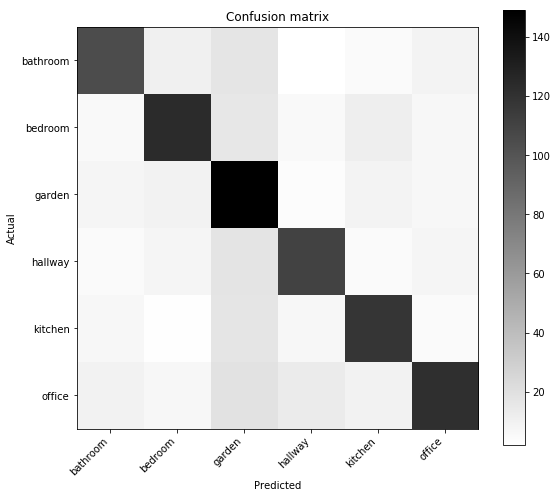

In [6]:
cm.plot()

In [7]:
y_proba_predict = grid.predict_proba(X_test)

print X_test.iloc[0], y_test.iloc[0]
print y_proba_predict[0]

# 96% sure that john is in the hallway, as one of the given facts attests to it

fact1        John travelled to the hallway.
fact2       Mary journeyed to the bathroom.
question                    Where is John? 
Name: 0, dtype: object answer    hallway
Name: 0, dtype: object
[0.00609621 0.0045135  0.00675367 0.97510844 0.00395894 0.00356923]


In [8]:
print X_test.iloc[1], y_test.iloc[1]
print y_proba_predict[1]

# impossible to know from the given facts where john is, low probabilities

fact1       Daniel went back to the bathroom.
fact2              John moved to the bedroom.
question                      Where is Mary? 
Name: 1, dtype: object answer    bathroom
Name: 1, dtype: object
[0.17295714 0.18281902 0.20282048 0.15167267 0.14234876 0.14738194]
